# Background info

### Microphysical parameters (xnames)

Note that the parameter names in the namelist correspond to the microphysics Fortran code, not the Python codes used in ensemble DA experiments. Definitions are as follows:

1. as = a_s, the coefficient in the snow fallspeed-diameter relationship
2. bs = b_s, the exponent in the snow fallspeed-diameter relationship
3. ag = a_g, the coefficient in the graupel fallspeed-diameter relationship
4. bg = b_g, the exponent in the graupel fallspeed-diameter relationship
5. tnw = N_0r, the intercept parameter in the (exponential) rain particle size distribution
6. tns = N_0s, the intercept parameter in the (exponential) snow particle size distribution
7. tng = N_0g, the intercept parameter in the (exponential) graupel particle size distribution
8. roqs = rho_s, the snow density
9. roqg = rho_g, the graupel density
10. bnd21 = q_c0, the cloud-to-rain autoconversion threshold
11. bnd1 = q_i0, the ice-to-snow autoconversion threshold (not used) 

### Model output (ynames)

Running the cloud column model (CRM) will produce an ascii file (eg, crm1d_output.txt) containing a row of numbers (the default run contains 36 values in total).

If the model is run for 1 time step only, it will output 6 values corresponding to the following variables:

1. pcp: precipitation rate
2. acc: accumulated precipitation
3. lwp: liquid water path
4. iwp: ice water path
5. olr: outgoing longwave radiation
6. osr: outgoing shortwave radiation

If the model is run for "k" time steps, there will be a total of 6k values, where each set of 6 values (counting from the beginning) will correspond to the 6 variables above. E.g., the second 6-member set (starting from the 7th value and ending in the 12th value), will give the values of {pcp,acc,lwp,iwp,olr,osr} during the second model time step.

In [ ]:
#----------------
#    PACKAGES    
#----------------
import time
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from cloud_column_model import cloud_column_model 
import create_ensemble
from parmap_framework import parmap
from module_runcrm import runcrm
import csv 
import pandas as pd

#--------------------------------
#    EXPERIMENT CONFIGURATION         
#--------------------------------

### General
rand_seed = 33; np.random.seed(rand_seed) # set random number seed for reproducibility
num_Workers = 12
np.set_printoptions(precision=5) 
np.set_printoptions(suppress=True) # suppress scientific notation

### Input/output filenames
expdir = './'
input_file = expdir+'cloud_column_model/run_one_crm1d.txt' # in cloud_column_column_model dir; contains reference param vals
output_file = expdir+'cloud_column_model/crm1d_output.txt' # appears in cloud_column_model dir under the name pert_crm1d_output.txt_{num}
                                        # each column shows time evolution for 1 of the 6 model output vars 
namelist_file = expdir+'cloud_column_model/namelist_3h_t30-180.f90'

### Ensembles and distributions
LType = 1 # Gaussian likelihood by default; corresponds to additive and Gaussian noise
ens_gen = 'uniform'
n_ens = 1000 # 1000 used in Posselt and Bishop (2018)
p1 = [              200.0,  0.3,  400.0,  0.4,  0.5,    0.5,   0.5,   0.2,     0.4,   1.e-3,  6.e-4 ] # mean parameter used in create_ensemble()
                                                                                                      # to define Gaussian and Gamma distributions
p2 = [              20.0,   0.05, 20.0,   0.05, 0.05,   0.05,  0.05,  0.05,    0.05,  1.e-4,  1.e-5 ] # std parameter used in create_ensemble() 
                                                                                                      # to define Gaussian and Gamma distributions
pmin = [            50.0,   0.10, 50.0,   0.1,  0.00,   0.00,  0.00,  0.1,    0.1,  1.e-1,  2.e-6 ] # lower bound
pmax = [            1000.0, 1.0,  1200.0, 0.90, 5.0,    5.0,   5.0,   1.0,     1.0,   3.e-0,  1.e-3 ] # upper bound

### Parameters and observations
# parameters
xnames = [        'as',   'bs',  'ag',  'bg', 'N0r',  'N0s', 'N0g', 'rhos',  'rhog', 'qc0', 'qi0']
XfMask = np.array([0.0,    0.0,  1.0,    1.0,  0.0,    0.0,   0.0,   0.0,     0.0,    0.0,   0.0])
x_true = [         200.0,  0.3,  400.0,  0.4,  0.5,    0.5,   0.5,   0.2,     0.4,   1.e-3,  6.e-4 ]
nx = len(xnames)
nxp = np.count_nonzero(XfMask) 
xidx = np.squeeze(np.nonzero(XfMask))
# times
tnames =          ['30', '60', '90', '120', '150', '180']
t_mask = np.array([1.0,  1.0,   1.0,  1.0,   1.0,   1.0])
nt = len(tnames)
# observations
ynames =          ['PCP', 'ACC', 'LWP', 'IWP', 'OLR', 'OSR']
y_mask = np.array([ 1.0,   0.0,   1.0,   1.0,   1.0,   1.0])
y_sigma =         [ 2.0,   5.0,   0.5,   1.0,   5.0,   5.0 ] * nt
ynames_long = [f'{y}_t{i}' for i in range(1, nt+1) for y in ynames]
n_obs = len(ynames)

### Full observation space mask
HXfMask = np.empty(n_obs * nt)
for t in range(nt):
  for o in range(n_obs):
    idx = (t * n_obs) + o
    HXfMask[idx] = t_mask[t] * y_mask[o]

In [2]:
#--------------------------------
#    MODEL SIMULATIONS         
#--------------------------------

### Generate prior ensemble X
print('Generating the prior ensemble')
p1_in   = (np.array(p1)[xidx]).tolist() # mean of selected state vars
p2_in   = (np.array(p2)[xidx]).tolist() # std of -||-
pmin_in = (np.array(pmin)[xidx]).tolist() # lower bound of -||-
pmax_in = (np.array(pmax)[xidx]).tolist() # upper bound of -||-
# only perturb selected state vars; Xf dims will be [Ne,Nx_selected]
Xf_subset = create_ensemble.create_ensemble(n_ens,p1_in,p2_in,pmin_in,pmax_in,ens_gen)
print('     Shape of Xf with selected vars:   ',np.array(Xf_subset).shape)
# now construct the full prior ensemble in which selected vars are perturbed
# and masked variables are set to their true values for all ensemble members
Xf_mask = np.tile(x_true,n_ens).reshape(n_ens,len(x_true))
Xf_mask[:,xidx] = np.array(Xf_subset)
Xf = Xf_mask.tolist() # list in the form [[parms_mem{1}],...,[parms_mem{n_ens}]]
                        # where parms_mem{k} is made of the 11 state vars (CRM params)
print('     Shape of Xf with all vars:        ',np.array(Xf).shape)
print('     Prior mean (Xf.mean):             ',np.mean(Xf,axis=0)[xidx])
print('     Prior variance (Xf.var):          ',np.var(Xf,axis=0)[xidx])


### Mapping prior ensemble to observation space h(X) (i.e., run ensemble of CRM simulations)
print('Mapping prior ensemble to observation space (running the cloud model)')
runs = [] # full input list for the ensemble CRM runs
input_file_list = [input_file] * n_ens
output_file_list = [output_file] * n_ens
namelist_file_list = [namelist_file] * n_ens
run_num_list = list(range(1,n_ens+1))
runs = [list(x) for x in zip(input_file_list, output_file_list, namelist_file_list, run_num_list, Xf)]
print(f'    Full input to first ensemble member: {runs[0]}')
DASK_URL = 'scispark6.jpl.nasa.gov:8786'
parmode = 'par'
pmap = parmap.Parmap(master=DASK_URL, mode=parmode, numWorkers=num_Workers)
HXf = pmap(runcrm, runs)
print('    State vector for ens member Ne/2:  ', Xf[np.int32(n_ens/2)])
print('    ObSpace-mapped state vector for ens member Ne/2: ', HXf[np.int32(n_ens/2)])
print('    len(HXf), len(HXf[1]): ',len(HXf),len(HXf[0]))

Generating the prior ensemble
     Shape of Xf with selected vars:    (1000, 2)
     Shape of Xf with all vars:         (1000, 11)
     Prior mean (Xf.mean):              [618.94684   0.50474]
     Prior variance (Xf.var):           [109954.43371      0.05424]
Mapping prior ensemble to observation space (running the cloud model)
    Full input to first ensemble member: ['./cloud_column_model/run_one_crm1d.txt', './cloud_column_model/crm1d_output.txt', './cloud_column_model/namelist_3h_t30-180.f90', 1, [200.0, 0.3, 335.7866465533894, 0.4599803368406364, 0.5, 0.5, 0.5, 0.2, 0.4, 0.001, 0.0006]]



parmap <function runcrm at 0x136081620>: Running in mode par with numPartitions 12


Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        58.2910804749      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        53.0720100403      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        72.6106414795      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        74.1043777466      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        50.4893951416      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000     

In [3]:


#------------------------
#    TRUE SIMULATION            
#------------------------

### Run the cloud model with the true parameters
print('*** TRUE SIMILATION ***')
crm1d = cloud_column_model.CRM1DWrap(input_file,output_file,namelist_file, params=x_true,verbose=True)
y_true, crm_status = crm1d() # a list of len(y_true) = nt*n_obs
print('Output: ',len(y_true),y_true)  





*** TRUE SIMILATION ***
Parameter values to be used in cloud_column_model.py:  200.0 0.3 400.0 0.4 0.5 0.5 0.5 0.2 0.4 0.001 0.0006
Input file name:     ./cloud_column_model/run_one_crm1d.txt-CRM1D-c225a3642c
Output file name:    ./cloud_column_model/crm1d_output.txt-CRM1D-29fc716db2
Namelist file name:  ./cloud_column_model/namelist_3h_t30-180.f90
Output:  36 [3.7471554279, 0.0863199979, 5.0852060318, 0.0008276912, 240.7512512207, 896.9626464844, 7.9930844307, 3.937908411, 4.4381356239, 4.5186429024, 153.4401702881, 804.2377929688, 6.2555627823, 7.6948990822, 2.8587121964, 12.063126564, 160.9409637451, 848.690612793, 12.8107385635, 11.4412117004, 5.5484800339, 14.7016458511, 195.8087310791, 803.0979003906, 18.7041091919, 21.073266983, 5.6027178764, 11.48528862, 212.2489471436, 737.3928222656, 20.8552017212, 30.281162262, 6.4446291924, 3.7101278305, 231.7576751709, 493.205291748]


Saving CSV file (Input Parametes and Output Parametes)


[---------------------Graupel fall speed coefficient, Ag Vs outputs----------------------------------]

In [4]:
import pandas as pd

input_csv_path = './cloud_column_model/ensemble_input.csv'
output_csv_path = './cloud_column_model/ensemble_output.csv'

# Define column names for the input parameters
column_names_input = ['as', 'bs', 'ag', 'bg', 'N0r', 'N0s', 'N0g', 'rhos', 'rhog', 'qc0', 'qi0']

# Save input ensemble (Xf) to a CSV file
Xf_df = pd.DataFrame(Xf, columns=column_names_input)
Xf_df.to_csv(input_csv_path, index=False)
print(f"Input parameters for 1 ensembles saved to {input_csv_path}")

# Define column names for the output variables
column_names_output = [f"{var}_t{t}" for t in range(1, nt + 1) for var in ynames]

# Save output ensemble (HXf) to a CSV file
HXf_df = pd.DataFrame(HXf, columns=column_names_output)
HXf_df.to_csv(output_csv_path, index=False)
print(f"Output variables for 1 ensembles saved to {output_csv_path}")


Input parameters for 1 ensembles saved to ./cloud_column_model/ensemble_input.csv
Output variables for 1 ensembles saved to ./cloud_column_model/ensemble_output.csv


In [ ]:
"""
Cloud Column Model Parameter Sweep with Parallel Processing

This script performs a parameter sweep for the 'ag' parameter in a cloud column model simulation
It uses a parallel execution framework to run multiple instances of the CRM model with varying 'ag' values 
and saves the ensemble output to a CSV file

Key Features:
1. Fixed input parameters for the CRM model are defined in the `fixed_values` dictionary
2. The 'ag' parameter varies from 50 to 1200, incremented by 1
3. Input data is prepared for each run, including both fixed and varying parameters
4. Parallel processing is implemented using DASK via the `parmap_framework` package
5. Outputs of the CRM model are aggregated into a DataFrame and saved as a CSV

Dependencies:
- pandas
- numpy
- parmap_framework
- module_runcrm (containing the `runcrm` function)

Workflow:
1. Prepare a list of input configurations (`runs`) for all parameter sweep iterations
2. Execute the runs in parallel using the DASK cluster
3. Process and organize the output data into a DataFrame with appropriate column names
4. Save the DataFrame to a CSV file for further analysis

Output:
- CSV file containing the ensemble output for all 'ag' values, with 36 output variables 
  (6 variables x 6 time steps) and the corresponding 'ag' values

Usage:
Ensure all dependencies are installed, and paths for input/output files are correct before execution
"""

import pandas as pd
import numpy as np
from parmap_framework import parmap
from module_runcrm import runcrm 

# File path for saving the output
output_csv_path = './cloud_column_model/ensemble_output_ag_vary.csv'

# Fixed values for input parameters
fixed_values = {
    'as': 200.0,
    'bs': 0.3,
    'bg': 0.4,
    'N0r': 0.5,
    'N0s': 0.5,
    'N0g': 0.5 ,
    'rhos': 0.2,
    'rhog':  0.4,
    'qc0': 0.001,
    'qi0': 0.0006
} 
# Define the range for 'ag' parameter
ag_values = np.arange(50, 1201, 1.151)  # From 50 to 1200 with increment of 1

# Prepare input data for each iteration
runs = []
for ag in ag_values:
    input_params = list(fixed_values.values())
    input_params.insert(2, ag)  # Insert the varying 'ag' value in the correct position
    runs.append([
        './cloud_column_model/run_one_crm1d.txt',  # Input file (placeholder)
        './cloud_column_model/crm1d_output.txt',  # Output file (placeholder)
        './cloud_column_model/namelist_3h_t30-180.f90',  # Namelist file
        len(runs) + 1,  # Run number
        input_params  # Parameters for this run
    ])

# Print a sample input for debugging
print(f"Sample input for first iteration: {runs[0][-1]}")


# Parallel execution using DASK
DASK_URL = 'scispark6.jpl.nasa.gov:8786'
parmode = 'par'
num_Workers = 12
pmap = parmap.Parmap(master=DASK_URL, mode=parmode, numWorkers=num_Workers)
HXf = pmap(runcrm, runs)

# Print a sample output for debugging
print('Output for first ensemble member:', HXf[0])
print('len(HXf), len(HXf[0]):', len(HXf), len(HXf[0]))

# Define column names for the output variables (6 variables x 6 time steps)
column_names_output = [f"{var}_t{t}" for t in range(1, 7) for var in ['PCP', 'ACC', 'LWP', 'IWP', 'OLR', 'OSR']]

# Convert the full output (36 columns per member) to a DataFrame
HXf_df = pd.DataFrame(HXf, columns=column_names_output)

# Add the 'ag' values as a separate column for reference
HXf_df.insert(0, 'ag', ag_values)

# Save to CSV
HXf_df.to_csv(output_csv_path, index=False)
print(f"New ensemble outputs with varying 'ag' saved to {output_csv_path}")


Sample input for first iteration: [200.0, 0.3, 50.0, 0.4, 0.5, 0.5, 0.5, 0.2, 0.4, 0.001, 0.0006]



parmap <function runcrm at 0x136081620>: Running in mode par with numPartitions 12


Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        74.1709976196      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        50.0000000000      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        51.1510009766      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        52.3019981384      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        53.4529991150      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000     

Creating a new file which will be used as input file in the cloud model for testing. Ag value is fixed while other parameters value is remained as TRUE value

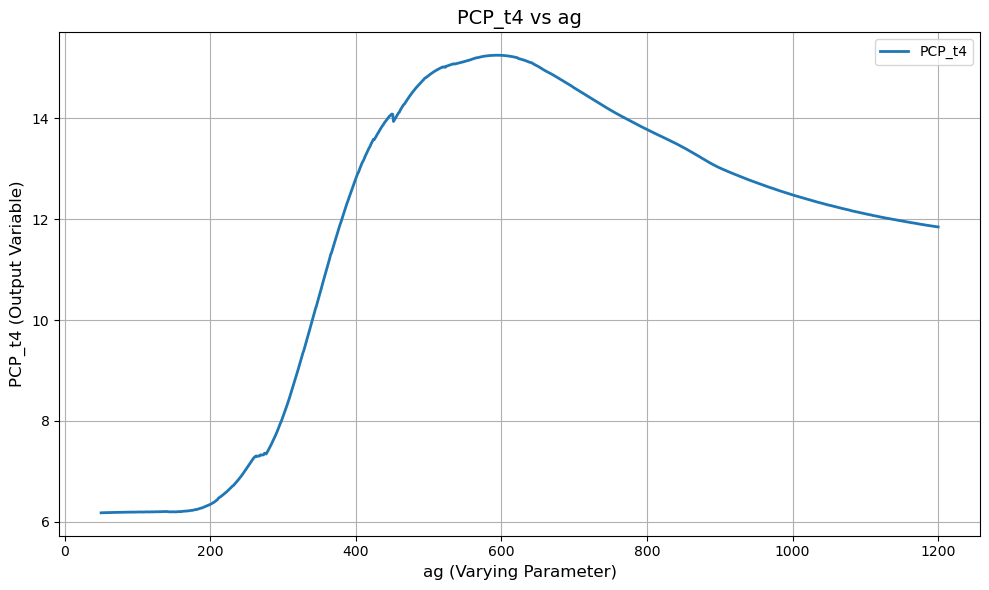

In [6]:
# Load the output data
output_data = pd.read_csv(output_csv_path)

# Extract 'ag' and 'PCP_t4' values
ag_values_plot = output_data['ag']
pcp_t4_values = output_data['PCP_t4']

# Plot 'ag' vs 'PCP_t4'
plt.figure(figsize=(10, 6))
plt.plot(ag_values_plot, pcp_t4_values, label='PCP_t4', linewidth=2)
plt.xlabel('ag (Varying Parameter)', fontsize=12)
plt.ylabel('PCP_t4 (Output Variable)', fontsize=12)
plt.title('PCP_t4 vs ag', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
"""
Cloud Column Model Parameter Sweep with Parallel Processing

This script performs a parameter sweep for the 'ag' parameter in a cloud column model simulation.
It uses a parallel execution framework to run multiple instances of the CRM model with varying 'ag' values 
and saves the ensemble input configurations and output results to CSV files.

Key Features:
1. Fixed input parameters for the CRM model are defined in the `fixed_values` dictionary.
2. The 'ag' parameter varies from 50 to 1200, incremented by 1.
3. Input data is prepared for each run, including both fixed and varying parameters.
4. Parallel processing is implemented using DASK via the `parmap_framework` package.
5. Outputs of the CRM model are aggregated into a DataFrame and saved as a CSV.

Dependencies:
- pandas
- numpy
- parmap_framework
- module_runcrm (containing the `runcrm` function)

Outputs:
1. `ensemble_inputs_ag_vary.csv`: Input configurations for all 'ag' values.
2. `ensemble_output_ag_vary.csv`: Ensemble output for all 'ag' values.

Usage:
Ensure all dependencies are installed, and paths for input/output files are correct before execution.
"""

import pandas as pd
import numpy as np
from parmap_framework import parmap
from module_runcrm import runcrm

# File paths for saving input configurations and output results
input_csv_path = './cloud_column_model/ensemble_inputs_ag_vary.csv'
output_csv_path = './cloud_column_model/ensemble_output_ag_vary.csv'

# Fixed values for input parameters
fixed_values = {
    'as': 200.0,
    'bs': 0.3,
    'bg': 0.4,
    'N0r': 0.5,
    'N0s': 0.5,
    'N0g': 0.5,
    'rhos': 0.2,
    'rhog': 0.4,
    'qc0': 0.001,
    'qi0': 0.0006
}

# Define the range for the 'ag' parameter
ag_values = np.arange(50, 1201, 1.151)  # From 50 to 1200 with increment of 1

# Prepare input data for each iteration
runs = []
for ag in ag_values:
    input_params = list(fixed_values.values())
    input_params.insert(2, ag)  # Insert the varying 'ag' value in the correct position
    runs.append([
        './cloud_column_model/run_one_crm1d.txt',  # Input file (placeholder)
        './cloud_column_model/crm1d_output.txt',  # Output file (placeholder)
        './cloud_column_model/namelist_3h_t30-180.f90',  # Namelist file
        len(runs) + 1,  # Run number
        input_params  # Parameters for this run
    ])

# Save all input configurations to a CSV file
input_columns = list(fixed_values.keys())
input_columns.insert(2, 'ag')  # Insert 'ag' in the correct position
input_data = pd.DataFrame([run[-1] for run in runs], columns=input_columns)
input_data.to_csv(input_csv_path, index=False)
print(f"Input configurations with varying 'ag' saved to {input_csv_path}")

# Parallel execution using DASK
DASK_URL = 'scispark6.jpl.nasa.gov:8786'
parmode = 'par'
num_Workers = 12
pmap = parmap.Parmap(master=DASK_URL, mode=parmode, numWorkers=num_Workers)
HXf = pmap(runcrm, runs)

# Print a sample output for debugging
print('Output for first ensemble member:', HXf[0])
print('len(HXf), len(HXf[0]):', len(HXf), len(HXf[0]))

# Define column names for the output variables (6 variables x 6 time steps)
column_names_output = [f"{var}_t{t}" for t in range(1, 7) for var in ['PCP', 'ACC', 'LWP', 'IWP', 'OLR', 'OSR']]

# Convert the full output (36 columns per member) to a DataFrame
HXf_df = pd.DataFrame(HXf, columns=column_names_output)

# Add the 'ag' values as a separate column for reference
HXf_df.insert(0, 'ag', ag_values)

# Save the ensemble output to a CSV file
HXf_df.to_csv(output_csv_path, index=False)
print(f"New ensemble outputs with varying 'ag' saved to {output_csv_path}")


Input configurations with varying 'ag' saved to ./cloud_column_model/ensemble_inputs_ag_vary.csv



parmap <function runcrm at 0x136081620>: Running in mode par with numPartitions 12


Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        74.1709976196      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        50.0000000000      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        51.1510009766      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        52.3019981384      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000        53.4529991150      1200.0000000000
Warning! Parameter outside allowable range
Ensemble member, parameter number, min, value, max:          1   3        75.0000000000     

Epoch 1/20000: Train Loss = 0.542463, Test Loss = 0.367280, Learning Rate = 1.000000e-03
Epoch 2/20000: Train Loss = 0.477496, Test Loss = 0.369548, Learning Rate = 9.996200e-04
Epoch 3/20000: Train Loss = 0.490221, Test Loss = 0.273737, Learning Rate = 9.992402e-04
Epoch 4/20000: Train Loss = 0.476921, Test Loss = 0.304057, Learning Rate = 9.988605e-04
Epoch 5/20000: Train Loss = 0.463274, Test Loss = 0.316549, Learning Rate = 9.984810e-04
Epoch 6/20000: Train Loss = 0.503702, Test Loss = 0.277283, Learning Rate = 9.981016e-04
Epoch 7/20000: Train Loss = 0.469952, Test Loss = 0.258173, Learning Rate = 9.977223e-04
Epoch 8/20000: Train Loss = 0.454740, Test Loss = 0.270687, Learning Rate = 9.973432e-04
Epoch 9/20000: Train Loss = 0.456667, Test Loss = 0.275984, Learning Rate = 9.969643e-04
Epoch 10/20000: Train Loss = 0.458708, Test Loss = 0.231470, Learning Rate = 9.965854e-04
Epoch 11/20000: Train Loss = 0.452379, Test Loss = 0.232411, Learning Rate = 9.962068e-04
Epoch 12/20000: Tra

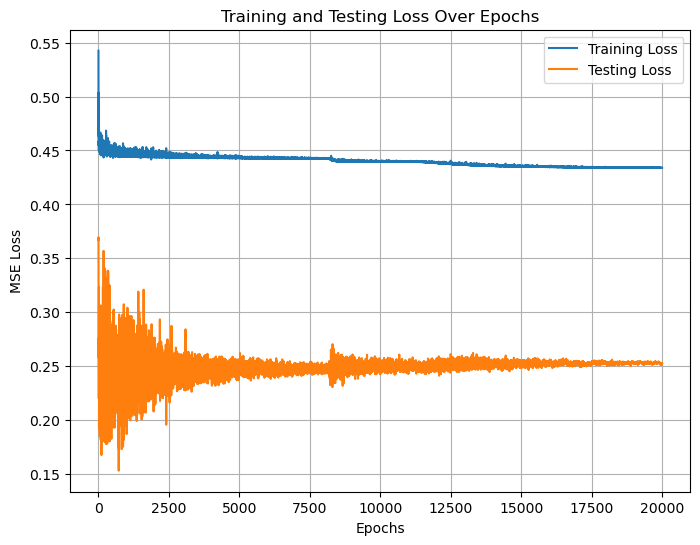

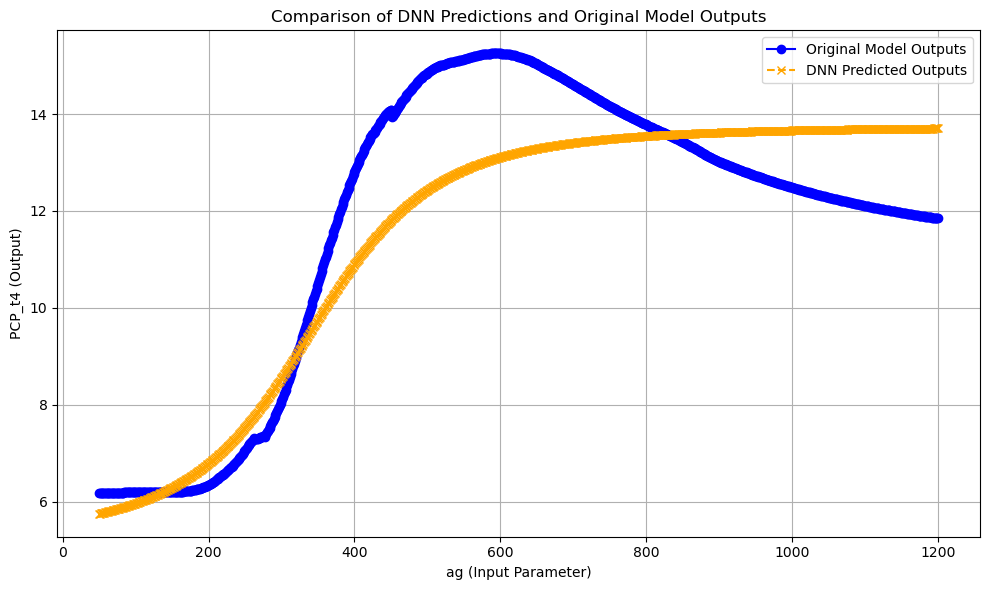

Comparison of predictions saved to ./cloud_column_model/comparison_predictions.csv


In [ ]:
import os
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ==============================================
# PART 1: Data Loading and Preprocessing
# ==============================================

# Load input and output data from CSV files
input_csv_path = './cloud_column_model/ensemble_input.csv'
output_csv_path = './cloud_column_model/ensemble_output.csv'
new_input_csv_path = './cloud_column_model/ensemble_new_input_ag_vary.csv'
output_comparison_csv_path = './cloud_column_model/ensemble_output_ag_vary.csv'

# Load the input data
input_data = pd.read_csv(input_csv_path)
output_data = pd.read_csv(output_csv_path)
new_input_data = pd.read_csv(new_input_csv_path)
comparison_output_data = pd.read_csv(output_comparison_csv_path)

# Select only the 'ag' input and 'PCP_t4' output
input_data_ag = input_data[['ag']]
output_data_t4 = output_data[['PCP_t4']]
test_input_data_ag = new_input_data[['ag']]  # Renamed for clarity
comparison_output_data_t4 = comparison_output_data[['PCP_t4']]

# Convert input and output data to numpy arrays
Xf = input_data_ag.values  # Input features
HXf_t4 = output_data_t4.values  # Outputs (only PCP_t4)
test_Xf = test_input_data_ag.values
comparison_Y = comparison_output_data_t4.values

# Normalize the data using StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

Xf_scaled = scaler_X.fit_transform(Xf)
HXf_t4_scaled = scaler_Y.fit_transform(HXf_t4)
test_Xf_scaled = scaler_X.transform(test_Xf)
comparison_Y_scaled = scaler_Y.transform(comparison_Y)

# ==============================================
# PART 2: Define and Train the Neural Network Model
# ==============================================

# Model parameters
layers = 10  # Number of hidden layers
nodes_per_layer = 100  # Number of nodes per hidden layer
total_epochs = 20000  # Total number of training epochs
init_rate = 0.001  # Initial learning rate
batch_size = 32  # Batch size for training

# Define the DNN model
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, layers, nodes_per_layer):
        super(DNN, self).__init__()
        layers_list = [nn.Linear(input_dim, nodes_per_layer), nn.Tanh()]
        for _ in range(layers):
            layers_list.extend([nn.Linear(nodes_per_layer, nodes_per_layer), nn.Tanh()])
        layers_list.append(nn.Linear(nodes_per_layer, output_dim))
        self.layers = nn.Sequential(*layers_list)
    
    def forward(self, x):
        return self.layers(x)

# Weight initialization function
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize the model and apply weight initialization
model = DNN(Xf_scaled.shape[1], HXf_t4_scaled.shape[1], layers, nodes_per_layer).to(device)
model.apply(weights_init)

# Set up optimizer, scheduler, and loss function
optimizer = optim.Adam(model.parameters(), lr=init_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(5e-7 / init_rate) ** (1 / total_epochs))
criterion = nn.MSELoss()

# Prepare dataloader for training
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xf_scaled).float(), torch.from_numpy(HXf_t4_scaled).float()),
    batch_size=batch_size,
    shuffle=True
)

# Training loop
best_model = copy.deepcopy(model)
best_loss = float('inf')
patience = 50000
patience_counter = 0
train_losses = []
test_losses = []
lrs = []

for epoch in range(total_epochs):
    model.train()
    epoch_training_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item() * x_batch.size(0)

    epoch_training_loss /= len(Xf_scaled)
    train_losses.append(epoch_training_loss)

    # Testing on the test dataset
    model.eval()
    epoch_testing_loss = 0.0
    with torch.no_grad():
        test_outputs = model(torch.from_numpy(test_Xf_scaled).float().to(device))
        epoch_testing_loss = criterion(
            test_outputs,
            torch.from_numpy(comparison_Y_scaled).float().to(device)
        ).item()
    test_losses.append(epoch_testing_loss)

    # Check for improvement
    if epoch_testing_loss < best_loss:
        best_loss = epoch_testing_loss
        best_model = copy.deepcopy(model)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

    # Record and print the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lrs.append(current_lr)
    print(f"Epoch {epoch+1}/{total_epochs}: "
          f"Train Loss = {epoch_training_loss:.6f}, "
          f"Test Loss = {epoch_testing_loss:.6f}, "
          f"Learning Rate = {current_lr:.6e}")

    # Update learning rate
    scheduler.step()

# Restore the best model obtained during training
model = best_model

# ==============================================
# PART 3: Predict and Compare Results
# ==============================================

# Generate new 'ag' values
new_ag_values = np.arange(50, 1201, 1.151)  # From 50 to 1200 with increment of 1
new_ag_values_scaled = scaler_X.transform(new_ag_values.reshape(-1, 1))

# Predict using the trained DNN model
model.eval()
with torch.no_grad():
    predictions_scaled_new_ag = model(torch.from_numpy(new_ag_values_scaled).float().to(device)).cpu().numpy()

# Inverse transform the predictions
predictions_new_ag = scaler_Y.inverse_transform(predictions_scaled_new_ag)

# Load original outputs for the new 'ag' values
original_outputs_new_ag = comparison_output_data['PCP_t4'].values

# ==============================================
# PART 4: Plotting Results
# ==============================================

# Plot Training and Testing Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Learning Rate vs. Epochs
plt.figure(figsize=(8, 6))
plt.plot(lrs, label='Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot Comparison: Original vs Predicted Outputs
plt.figure(figsize=(10, 6))
plt.plot(new_ag_values, original_outputs_new_ag, label='Original Model Outputs', marker='o', linestyle='-', color='blue')
plt.plot(new_ag_values, predictions_new_ag, label='DNN Predicted Outputs', marker='x', linestyle='--', color='orange')
plt.title('Comparison of DNN Predictions and Original Model Outputs')
plt.xlabel('ag (Input Parameter)')
plt.ylabel('PCP_t4 (Output)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save predictions and comparison data to a CSV file
comparison_df = pd.DataFrame({
    'ag': new_ag_values,
    'Original_Output': original_outputs_new_ag,
    'DNN_Predicted_Output': predictions_new_ag.flatten()
})
comparison_csv_path = './cloud_column_model/comparison_predictions.csv'
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"Comparison of predictions saved to {comparison_csv_path}")


In [ ]:
print("Xf_scaled mean and std:", Xf_scaled.mean(), Xf_scaled.std())
print("HXf_t4_scaled mean and std:", HXf_t4_scaled.mean(), HXf_t4_scaled.std()) 


Xf_scaled mean and std: 1.2434497875801754e-16 0.9999999999999999
HXf_t4_scaled mean and std: -3.659295089164516e-16 1.0


[--------------------- rho_g, the graupel density Vs other outputs----------------------------------]

In [1]:
"""
Cloud Column Model Parameter Sweep with Parallel Processing

This script performs a parameter sweep for the 'rhog' parameter in a cloud column model simulation
It uses a parallel execution framework to run multiple instances of the CRM model with varying 'rhog' values 
and saves the ensemble output to a CSV file

Key Features:
1. Fixed input parameters for the CRM model are defined in the `fixed_values` dictionary
2. The 'rhog' parameter varies from 0.1 to 1, incremented by 0.0009
3. Input data is prepared for each run, including both fixed and varying parameters
4. Parallel processing is implemented using DASK via the `parmap_framework` package
5. Outputs of the CRM model are aggregated into a DataFrame and saved as a CSV

Dependencies:
- pandas
- numpy
- parmap_framework
- module_runcrm (containing the `runcrm` function)

Workflow:
1. Prepare a list of input configurations (`runs`) for all parameter sweep iterations
2. Execute the runs in parallel using the DASK cluster
3. Process and organize the output data into a DataFrame with appropriate column names
4. Save the DataFrame to a CSV file for further analysis

Output:
- CSV file containing the ensemble output for all 'rhog' values, with 36 output variables 
  (6 variables x 6 time steps) and the corresponding 'rhog' values

Usage:
Ensure all dependencies are installed, and paths for input/output files are correct before execution
"""

import pandas as pd
import numpy as np
from parmap_framework import parmap
from module_runcrm import runcrm

# File path for saving the output
output_csv_path_rhog = './cloud_column_model/ensemble_output_rhog_vary.csv'

# Fixed values for input parameters
fixed_values = {
    'as': 200,
    'bs': 0.3,
    'ag': 400,
    'bg': 0.4,
    'N0r':0.5,
    'N0s': 0.5,
    'N0g': 0.5,
    'rhos': 0.2,
    'qc0': 0.001,
    'qi0': 0.0006
}

# Define the range for 'ag' parameter
rhog_values = np.arange(0.1, 1, 0.0009)  # From 0.1 to 1 with increment of 0.0009

# Prepare input data for each iteration
runs = []
for rhog in rhog_values:
    input_params = list(fixed_values.values())
    input_params.insert(8, rhog)  # Insert the varying 'rhog' value in the correct position
    runs.append([
        './cloud_column_model/run_one_crm1d.txt',  # Input file (placeholder)
        './cloud_column_model/crm1d_output.txt',  # Output file (placeholder)
        './cloud_column_model/namelist_3h_t30-180.f90',  # Namelist file
        len(runs) + 1,  # Run number
        input_params  # Parameters for this run
    ])

# Print a sample input for debugging
print(f"Sample input for first iteration: {runs[0][-1]}")

# Parallel execution using DASK
DASK_URL = 'scispark6.jpl.nasa.gov:8786'
parmode = 'par'
num_Workers = 12
pmap = parmap.Parmap(master=DASK_URL, mode=parmode, numWorkers=num_Workers)
HXf = pmap(runcrm, runs)

# Print a sample output for debugging
print('Output for first ensemble member:', HXf[0])
print('len(HXf), len(HXf[0]):', len(HXf), len(HXf[0]))

# Define column names for the output variables (6 variables x 6 time steps)
column_names_output = [f"{var}_t{t}" for t in range(1, 7) for var in ['PCP', 'ACC', 'LWP', 'IWP', 'OLR', 'OSR']]

# Convert the full output (36 columns per member) to a DataFrame
HXf_df = pd.DataFrame(HXf, columns=column_names_output)

# Add the 'ag' values as a separate column for reference
HXf_df.insert(0, 'rhog', rhog_values)

# Save to CSV
HXf_df.to_csv(output_csv_path_rhog, index=False)
print(f"New ensemble outputs with varying 'rhog' saved to {output_csv_path_rhog}")


Sample input for first iteration: [200, 0.3, 400, 0.4, 0.5, 0.5, 0.5, 0.2, 0.1, 0.001, 0.0006]



parmap <function runcrm at 0x15dc99a80>: Running in mode par with numPartitions 12


Output for first ensemble member: [3.7471554279, 0.0863199979, 5.0838737488, 0.0021726273, 240.758682251, 896.8100585938, 9.7006654739, 4.1479549408, 4.5859365463, 4.1558990479, 154.1160430908, 785.2816772461, 7.2581114769, 8.1785850525, 3.3773915768, 10.9536771774, 166.9486846924, 808.3519287109, 16.7680702209, 13.5256023407, 6.2727732658, 11.7516775131, 204.241394043, 765.5327758789, 17.2996482849, 23.8721046448, 5.0507102013, 9.2141370773, 213.2725830078, 738.844543457, 16.8713703156, 31.6702823639, 5.5008354187, 3.2548453808, 232.6736907959, 486.527923584]
len(HXf), len(HXf[0]): 1000 36
New ensemble outputs with varying 'rhog' saved to ./cloud_column_model/ensemble_output_rhog_vary.csv


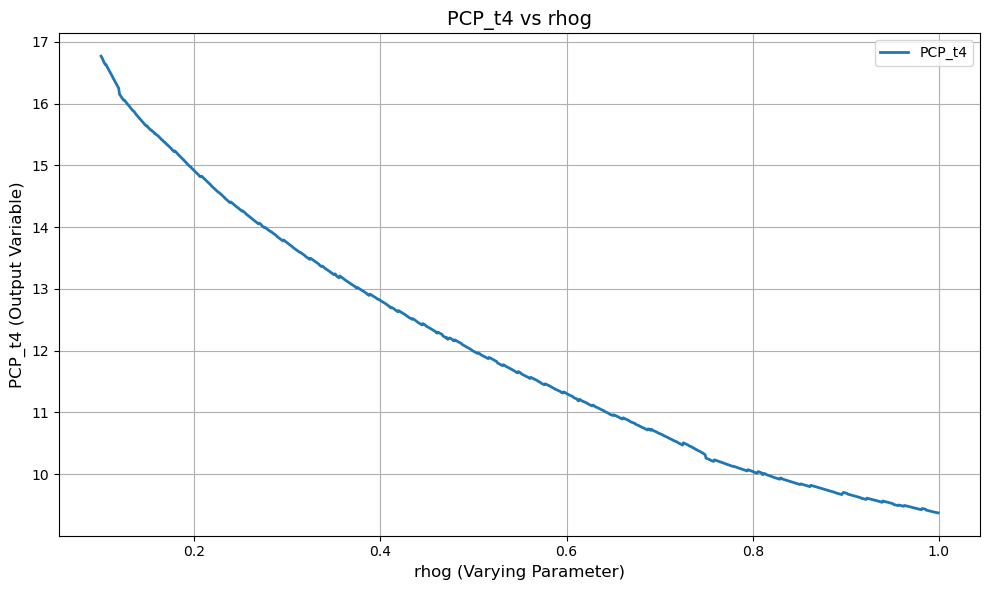

In [3]:
import matplotlib.pyplot as plt
# Load the output data
output_data = pd.read_csv(output_csv_path_rhog)

# Extract 'rhog' and 'PCP_t4' values
rhog_values_plot = output_data['rhog']
pcp_t4_values = output_data['PCP_t4']

# Plot 'ag' vs 'PCP_t4'
plt.figure(figsize=(10, 6))
plt.plot(rhog_values_plot,pcp_t4_values, label='PCP_t4', linewidth=2)
plt.xlabel('rhog (Varying Parameter)', fontsize=12)
plt.ylabel('PCP_t4 (Output Variable)', fontsize=12)
plt.title('PCP_t4 vs rhog', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Run the cloud Model where the previous step file has been used as input file to generate output 

In [12]:
import pandas as pd

# Define file paths for saving input and output
input_csv_path = './cloud_column_model/ensemble_input_1000.csv'
output_csv_path = './cloud_column_model/ensemble_output_1000.csv'

# Define column names for the input parameters
column_names_input = ['as', 'bs', 'ag', 'bg', 'N0r', 'N0s', 'N0g', 'rhos', 'rhog', 'qc0', 'qi0']

# Save input ensemble (Xf) to a CSV file
Xf_df = pd.DataFrame(Xf, columns=column_names_input)
Xf_df.to_csv(input_csv_path, index=False)
print(f"Input parameters for 1000 ensembles saved to {input_csv_path}")

# Define column names for the output variables
column_names_output = [f"{var}_t{t}" for t in range(1, nt + 1) for var in ynames]

# Save output ensemble (HXf) to a CSV file
HXf_df = pd.DataFrame(HXf, columns=column_names_output)
HXf_df.to_csv(output_csv_path, index=False)
print(f"Output variables for 1000 ensembles saved to {output_csv_path}")


ValueError: Shape of passed values is (1000, 1), indices imply (1000, 11)

In [ ]:
import pandas as pd
import numpy as np
from parmap_framework import parmap
from module_runcrm import runcrm

# File paths
new_input_csv_path = './cloud_column_model/ensemble_new_input_ag_vary.csv'
output_csv_path = './cloud_column_model/ensemble_output_ag_vary.csv'

# Load the new input file where 'ag' and 'bg' vary
ensemble_input = pd.read_csv(new_input_csv_path)

# Sort the input data by 'ag' and then by 'bg' values
ensemble_input_sorted = ensemble_input.sort_values(by=['ag', 'bg']).reset_index(drop=True)

# Define other required parameters
n_ens = len(ensemble_input_sorted)  # Number of ensemble members
input_file_list = ['./cloud_column_model/run_one_crm1d.txt'] * n_ens
output_file_list = ['./cloud_column_model/crm1d_output.txt'] * n_ens
namelist_file_list = ['./cloud_column_model/namelist_3h_t30-180.f90'] * n_ens
run_num_list = list(range(1, n_ens + 1))

# Prepare input data for CRM runs
runs = [list(x) for x in zip(input_file_list, output_file_list, namelist_file_list, run_num_list, ensemble_input_sorted.values.tolist())]

# Print a sample input for debugging
print(f"Full input to the first ensemble member: {runs[0]}")

# Parallel execution using DASK
DASK_URL = 'scispark6.jpl.nasa.gov:8786'
parmode = 'par'
num_Workers = 12
pmap = parmap.Parmap(master=DASK_URL, mode=parmode, numWorkers=num_Workers)
HXf = pmap(runcrm, runs)

# Print a sample output for debugging
print('Output for ensemble member Ne/2:', HXf[np.int32(n_ens / 2)])
print('len(HXf), len(HXf[0]):', len(HXf), len(HXf[0]))

# Define column names for the output variables (6 variables x 6 time steps)
column_names_output = [f"{var}_t{t}" for t in range(1, 7) for var in ['PCP', 'ACC', 'LWP', 'IWP', 'OLR', 'OSR']]

# Convert the full output (36 columns per member) to a DataFrame
HXf_df = pd.DataFrame(HXf, columns=column_names_output)

# Save to CSV
HXf_df.to_csv(output_csv_path, index=False)
print(f"New ensemble outputs saved to {output_csv_path}")


Visualize the input (ag) and PCP_t4

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
new_input_csv_path = './cloud_column_model/ensemble_new_input_ag_vary.csv'
output_csv_path = './cloud_column_model/ensemble_output_ag_vary.csv'

# Load the input and output data
input_data = pd.read_csv(new_input_csv_path)
output_data = pd.read_csv(output_csv_path)

# Sort the input data by 'ag' and align the output data
sorted_data = input_data.sort_values(by=['ag']).reset_index(drop=True)
sorted_output_data = output_data.loc[sorted_data.index].reset_index(drop=True)

# Extract 'ag' and 'PCP_t4' for plotting
x_values_sorted = sorted_data['ag']
y_values_sorted = sorted_output_data['PCP_t4']

# Plot the sorted graph
plt.figure(figsize=(10, 6))
plt.plot(x_values_sorted, y_values_sorted, label='PCP_t4', color='blue')
plt.xlabel('ag (Coefficient in Graupel Fallspeed-Diameter Relationship)')
plt.ylabel('PCP_t4 (Precipitation Rate at Time Step 4)')
plt.title('output_test_CRM_model (Actual - Sorted)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the sorted plot
plt.show()

# Check the number of points in the sorted x-axis and y-axis
num_x_points_sorted = len(x_values_sorted)
num_y_points_sorted = len(y_values_sorted)

print(f"Number of points mapped on the sorted x-axis (ag): {num_x_points_sorted}")
print(f"Number of points mapped on the sorted y-axis (PCP_t4): {num_y_points_sorted}")


Using Downsample and cubic Spline to make the graph smoother 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# File paths
new_input_csv_path = './cloud_column_model/ensemble_new_input_ag_vary.csv'
output_csv_path = './cloud_column_model/ensemble_output_ag_vary.csv'

# Load the input and output data
input_data = pd.read_csv(new_input_csv_path)
output_data = pd.read_csv(output_csv_path) 

# Extract 'ag' values from input data and 'PCP_t4' from output data
x_values = input_data['ag']
y_values = output_data['PCP_t4']

# Downsample the data by considering every 10 points
x_downsampled = x_values[::60]
y_downsampled = y_values[::60]

# Create cubic interpolation using the downsampled data
interp_func = interp1d(x_downsampled, y_downsampled, kind='cubic')

# Generate smooth points for a curve
x_smooth = np.linspace(x_downsampled.min(), x_downsampled.max(), 1000)  # 1000 evenly spaced points
y_smooth = interp_func(x_smooth)


# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(x_smooth, y_smooth, label='PCP_t4 (Interpolated)', color='blue', linewidth=2)

# Add downsampled data points for reference
plt.scatter(x_downsampled, y_downsampled, color='red', s=10, label='Downsampled Data')

# Adjust x and y ticks at intervals of 100 and 10
x_ticks = np.arange(x_smooth.min(), x_smooth.max() + 1, 100)
y_ticks = np.arange(y_smooth.min(), y_smooth.max() + 1, 5)
plt.xticks(x_ticks)
plt.yticks(y_ticks)

# Add labels, title, and grid
plt.xlabel('ag (Coefficient in Graupel Fallspeed-Diameter Relationship)')
plt.ylabel('PCP_t4 (Precipitation Rate at Time Step 4)')
plt.title('output_test_CRM_model (Actual) with Downsampling and Interpolation')
plt.grid(True)
plt.legend()
plt.tight_layout() 

# Display the plot
plt.show()


DNN Model

In [ ]:
import os
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ==============================================
# PART 1: Data Loading and Preprocessing
# ==============================================

# Load input and output data from CSV files
input_csv_path = './cloud_column_model/ensemble_input.csv'
output_csv_path = './cloud_column_model/ensemble_output.csv'
new_input_csv_path = './cloud_column_model/ensemble_new_input_ag_vary.csv'
output_comparison_csv_path = './cloud_column_model/ensemble_output_ag_vary.csv'

# Load the input data
input_data = pd.read_csv(input_csv_path)
output_data = pd.read_csv(output_csv_path)
new_input_data = pd.read_csv(new_input_csv_path)
comparison_output_data = pd.read_csv(output_comparison_csv_path)

# Select only the 'ag' input and 'PCP_t4' output
input_data_ag = input_data[['ag']]
output_data_t4 = output_data[['PCP_t4']]
test_input_data_ag = new_input_data[['ag']]  # Renamed for clarity
comparison_output_data_t4 = comparison_output_data[['PCP_t4']]

# Convert input and output data to numpy arrays
Xf = input_data_ag.values  # Input features
HXf_t4 = output_data_t4.values  # Outputs (only PCP_t4)
test_Xf = test_input_data_ag.values
comparison_Y = comparison_output_data_t4.values

# Normalize the data using StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

Xf_scaled = scaler_X.fit_transform(Xf)
HXf_t4_scaled = scaler_Y.fit_transform(HXf_t4)
test_Xf_scaled = scaler_X.transform(test_Xf)
comparison_Y_scaled = scaler_Y.transform(comparison_Y)

# ==============================================
# PART 2: Define and Train the Neural Network Model
# ==============================================

# Model parameters
layers = 10  # Number of hidden layers
nodes_per_layer = 100  # Number of nodes per hidden layer
total_epochs = 500  # Total number of training epochs
init_rate = 0.001  # Initial learning rate
batch_size = 32  # Batch size for training

# Define the DNN model
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, layers, nodes_per_layer):
        super(DNN, self).__init__()
        layers_list = [nn.Linear(input_dim, nodes_per_layer), nn.Tanh()]
        for _ in range(layers):
            layers_list.extend([nn.Linear(nodes_per_layer, nodes_per_layer), nn.Tanh()])
        layers_list.append(nn.Linear(nodes_per_layer, output_dim))
        self.layers = nn.Sequential(*layers_list)
    
    def forward(self, x):
        return self.layers(x)

# Weight initialization function
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize the model and apply weight initialization
model = DNN(Xf_scaled.shape[1], HXf_t4_scaled.shape[1], layers, nodes_per_layer).to(device)
model.apply(weights_init)

# Set up optimizer, scheduler, and loss function
optimizer = optim.Adam(model.parameters(), lr=init_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(5e-7 / init_rate) ** (1 / total_epochs))
criterion = nn.MSELoss()

# Prepare dataloader for training
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xf_scaled).float(), torch.from_numpy(HXf_t4_scaled).float()),
    batch_size=batch_size,
    shuffle=True
)

# Training loop
best_model = copy.deepcopy(model)
best_loss = float('inf')
patience = 50000
patience_counter = 0
train_losses = []
test_losses = []
lrs = []

for epoch in range(total_epochs):
    model.train()
    epoch_training_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item() * x_batch.size(0)

    epoch_training_loss /= len(Xf_scaled)
    train_losses.append(epoch_training_loss)

    # Testing on the test dataset
    model.eval()
    epoch_testing_loss = 0.0
    with torch.no_grad():
        test_outputs = model(torch.from_numpy(test_Xf_scaled).float().to(device))
        epoch_testing_loss = criterion(
            test_outputs,
            torch.from_numpy(comparison_Y_scaled).float().to(device)
        ).item()
    test_losses.append(epoch_testing_loss)

    # Check for improvement
    if epoch_testing_loss < best_loss:
        best_loss = epoch_testing_loss
        best_model = copy.deepcopy(model)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

    # Record and print the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    lrs.append(current_lr)
    print(f"Epoch {epoch+1}/{total_epochs}: "
          f"Train Loss = {epoch_training_loss:.6f}, "
          f"Test Loss = {epoch_testing_loss:.6f}, "
          f"Learning Rate = {current_lr:.6e}")

    # Update learning rate
    scheduler.step()

# Restore the best model obtained during training
model = best_model

# ==============================================
# PART 3: Predict and Compare Results
# ==============================================

# Make predictions on the test input data
model.eval()
with torch.no_grad():
    predictions_scaled = model(torch.from_numpy(test_Xf_scaled).float().to(device)).cpu().numpy()

# Inverse transform the predictions and comparison data
predictions = scaler_Y.inverse_transform(predictions_scaled)
comparison_Y = scaler_Y.inverse_transform(comparison_Y_scaled)

# ==============================================
# PART 4: Plotting Results
# ==============================================

# Plot Training and Testing Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Learning Rate
plt.figure(figsize=(8, 6))
plt.plot(lrs)
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

# Plot Predictions vs Ground Truth
plt.figure(figsize=(8, 6))
plt.plot(test_Xf, predictions, label='DNN Predictions', marker='o', linestyle='--')
plt.plot(test_Xf, comparison_Y, label='Ground Truth', marker='x', linestyle='-')
plt.title('Comparison of DNN Predictions and Ground Truth')
plt.xlabel('ag (Input Parameter)')
plt.ylabel('PCP_t4 (Output)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ==============================================
# Save ag, Predictions, and Ground Truth to CSV
# ==============================================

# Create a DataFrame with ag, predictions, and ground truth
results_df = pd.DataFrame({
    'ag': test_Xf.flatten(),  # Flatten to 1D for saving
    'DNN_Predictions_PCP_t4': predictions.flatten(),
    'Ground_Truth_PCP_t4': comparison_Y.flatten()
})

# Save the DataFrame to a CSV file
output_csv_path = './cloud_column_model/predictions_vs_ground_truth.csv'
results_df.to_csv(output_csv_path, index=False)

print(f"Results saved to {output_csv_path}")

# ==============================================
# Visualize the Results
# ==============================================

# Load the saved CSV file
results_df = pd.read_csv(output_csv_path)

# Downsample the data by selecting every 15th value
downsampled_results = results_df.iloc[::15]

# Plot the downsampled graph for DNN Predictions vs Ground Truth
plt.figure(figsize=(8, 6))
plt.plot(downsampled_results['ag'], downsampled_results['DNN_Predictions_PCP_t4'], 'o--', label='DNN Predictions')
plt.plot(downsampled_results['ag'], downsampled_results['Ground_Truth_PCP_t4'], 'x-', label='Ground Truth')
plt.title('Comparison of DNN Predictions and Ground Truth (Downsampled)')
plt.xlabel('ag (Input Parameter)')
plt.ylabel('PCP_t4 (Output)')
plt.legend()
plt.grid(True)
plt.show()
